In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
%pip list

In [ ]:
import tensorflow as tf
import os

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data' 

In [ ]:
os.listdir(os.path.join(data_dir,'normal'))

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [ ]:
import numpy as np

In [ ]:
%pip install matplotlib

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data')

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
#image represented as numpy array
batch[0].shape

In [ ]:
#class 1 =normal ECG
#class 0 =abnormal ECG
batch[1]

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x, y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()


In [ ]:
batch = scaled_iterator.next()

In [ ]:
batch[0].min()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

In [ ]:
train_size = int(len(data)*.70)
val_size = int(len(data)*.2)
test_size = int(len(data)*.10)

In [ ]:
val_size

In [ ]:
train_size

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(test)

Build  Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'],)


In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, validation_data=val, callbacks=[tensorboard_callback],batch_size =7,epochs=15,shuffle=True)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show() 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision:{pre.result().numpy()},recall:{re.result().numpy()},Accuracy:{acc.result()}')

Testing

In [ ]:
import cv2

abormal ECG

In [ ]:
img = cv2.imread('testmi.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

normal ECG

In [ ]:
img = cv2.imread('testnormal.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat < 0.6: 
    print(f'The ECG is abnormal and the driver is suffering from a heart attack.')
else:
    print(f'The ECG normal')

Save the ECG_Model

In [ ]:
hist.save(os.path.join('models','ECGclassifier.h5'))

# Load and test the mode

In [96]:
from tensorflow.keras.models import load_model

In [97]:
from matplotlib import pyplot as plt

In [98]:
model = load_model('models\\ECGclassifier.h5')

## Normal

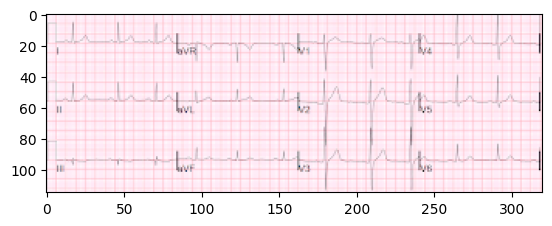

In [182]:
img = cv2.imread('Normal_ECG1.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

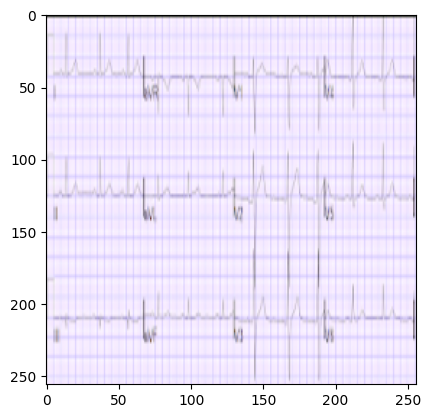

1/1 [==============================] - 0s 57ms/step
The ECG normal


In [183]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat < 0.6: 
    print(f'The ECG is abnormal and the driver is suffering from a heart attack.')
else:
    print(f'The ECG normal')

## abnormal

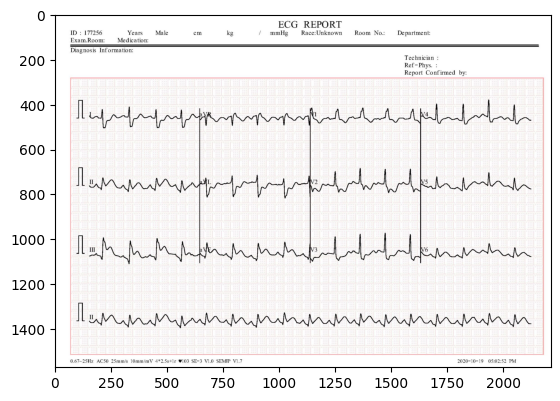

In [159]:
img = cv2.imread('mi4.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

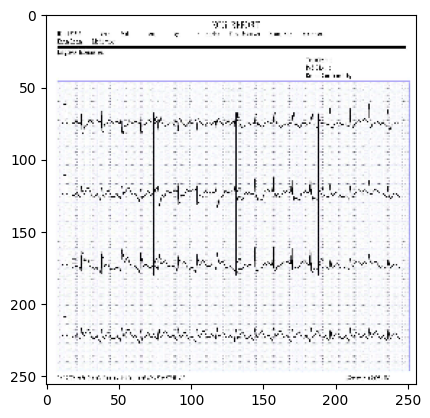

1/1 [==============================] - 0s 44ms/step
The ECG is abnormal and the driver is suffering from a heart attack.


In [161]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat < 0.6: 
    print(f'The ECG is abnormal and the driver is suffering from a heart attack.')
else:
    print(f'The ECG normal')